In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import Production
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\ProductionDynamic'

The file_gams_py_gdb1.gdx is still active and was not deleted.


### *1: Read in data*

*Load IO data:*

In [2]:
GE_data = DataBase.GPM_database(pickle_path=data_folder+'\\GE_data')

*Load global settings:*

In [3]:
with open(data_folder+'\\Ex1_gs',"rb") as file:
    gs = pickle.load(file)

*Define settings for the module:*

In [4]:
name_module = 'p'
trees = {'a': {'file': 'S1.xlsx', 'sheets': ['lower_nests', 'upper_nest']}, 
         'b': {'file': 'S2.xlsx', 'sheets': ['lower_nests', 'upper_nest']}}
temp_namespace = {'a': 'a_in', 'b':'b_in'} # used when reading in nesting trees, to distinguish input and output elements with identical names.
kwargs_st = {'sector': True, 'ss': GE_data.get('s_prod')} # settings for initializing the module

*Read in data to nesting tree:*

In [5]:
nts = {}
for s,t in trees.items():
    nts[s] = nesting_tree.nesting_tree(name=name_module) # initialize tree
    for tree in t['sheets']:
        nts[s].add_tree(data_folder+'\\'+t['file'],tree_name=tree,**{'sheet':tree}) # add nesting structure
        DataBase.GPM_database.merge_dbs(nts[s].trees[tree].database, excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+t['file'],{tree:'vars'}),'second') # add data
        if tree.startswith('lower'):
            nts[s].trees[tree].temp_namespace = temp_namespace
    nts[s].run_all(s0=s) # add default attributes from nesting structure
nesting_tree.merge_nts(list(nts.values())[0], list(nts.values())[1:]) # merge trees into one.
nt = list(nts.values())[0]

### *2: Static model:*

Start by setting up a static model from the nesting tree:

In [6]:
gm_static = Production.pr_static(nt=nt,work_folder = work_folder,**{'data_folder':work_folder,'name':'p_static'})

Add data from the general equilibrium data, but restrict it to the data on production sectors (not necessary, but neat):

In [7]:
GE_prod = small_updates.subset_db(GE_data.copy(),GE_data.get('s_prod'))

Due a temporary calibration of the model:

*1: Calibrate to inputs that are exogenous in the baseline settings:*

In [8]:
gm_static.write_and_run(name='v1',add_checkpoint='v1')
db_temp = gm_static.slice_exo(GE_prod,copy=True)
gm_static.model_instances['v1'].solve_sneakily(db_star=db_temp, from_cp = True, cp_init = gm_static.checkpoints['v1'], kwargs_shock={'n_steps':10})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*2: Read back solution to main db; drop all parameters/variables temporarily created in first step of calibration:* 

In [9]:
db = gm_static.model_instances['v1'].out_db
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_static.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_static.model.database.merge_dbs(gm_static.model.database,db,'second')

*3: calibrate to the other moments in the data:*

In [10]:
gm_static.reset_settings()
gm_static.setstate('DC')
db_temp = gm_static.slice_exo(GE_prod,copy=True)
gm_static.calibrate_sneaky(db_temp,**{'n_steps':100})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*Inspect solution compared to IO data:*

{'maxdiff': 0.0, 'plotdiff': None}


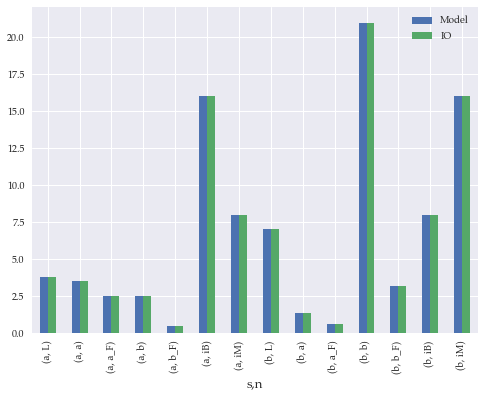

In [11]:
var,db = 'qD',gm_static.model_instances['baseline'].out_db
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,plot=False))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var)}).plot.bar(figsize=(8,6));

### *Dynamic model:*

Next, we set up the dynamic model, building on the static solution, as well as the IO data. Specifically, we: (1) Initialize using nesting structure, (2) add specification of durables from IO data, (3) Initialize parameter values and initial guess of variables using static model, (4) run.

In [12]:
gm_p = Production.pr_dynamic(nt=nt,work_folder=work_folder,kwargs_st = {'sector':True, 'ss': GE_data.get('s_prod')}, gs_v=gs,**{'data_folder':gams_folder,'name':name_module}) # initialize model.
gm_p.add_dur(GE_data.get('dur'),dur2inv = GE_data.get('dur2inv')) # add specification of durables
gm_p.ivfs(db,merge=False) # initialzie levels from static model
gm_p.initialize_variables(**{'check_variables': True}) # give all variables without a initial level some (semi) random number.
gm_p.model.database[gm_p.n('mu')].vals = db.get(gm_p.n('mu')) # update values of mu-parameters to static solution

Finally, update the prices $PwT$ on investment goods that are not automatically loaded from the static version (where the investment behavior was not included):

In [15]:
gm_p.model.database[gm_p.n('PwT')] = DataBase_wheels.repeat_variable_windex(GE_data['PwT'].rctree_pd(GE_data['inv']),gs.get('txE')).combine_first(gm_p.get('PwT'))

To calibrate to IO data, we start by adding the baseline year to the IO data:

In [16]:
GE_prod_t = DataBase.GPM_database()
for var in GE_prod.variables_flat:
    GE_prod_t[var] = DataBase_wheels.repeat_variable_windex(GE_prod.get(var),gm_p.get('t0'))

We further adjust the capital depreciation rates to ensure the model is in a steady state. The depreciation rates are then fitted to data at a later point in the proces (see Example1_cont.ipynb):

In [17]:
gm_p.ss_rDepr(GE_data)

The calibration method we apply form a grid of values between the database in the model, and the target database (GE\_prod\_t in this case),  and asks GAMS to solve the model on this grid. However, this only works on exogenous variables. To make sure that this works we do the following:
1. Set the *state* of the model to calibration.
2. Subset the target database *GE\_prod\_t* to only include exogenous variables (all *gmspython* models can access the exogenous/endogenous variables by calling the *self.var_exo(symbol)* method).
3. Run the calibration function.

In [18]:
gm_p.setstate('DC')

*Subset variables to exogenous variables:*

In [19]:
GE_prod_t = gm_p.slice_exo(GE_prod_t,copy=False)

*Calibrate sneakily (target the database GE\_prod\_t, if files w. same names exists overwrite them, sneak up on the solution in n\_steps):*

In [20]:
gm_p.calibrate_sneaky(GE_prod_t,overwrite=True,**{'n_steps': 10,'diff':True})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [21]:
db = gm_p.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_p.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_p.model.database.merge_dbs(gm_p.model.database,db,'second')
gm_p.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\ProductionDynamic\\gmspython_p'

*Inspect solution compared to IO data:*

{'maxdiff': 1.5065282354953524e-10, 'plotdiff': None}


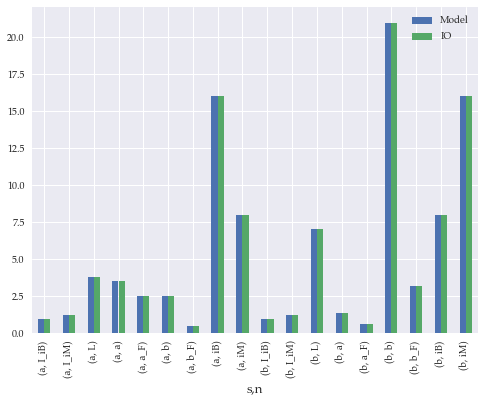

In [22]:
var,year,kwargs = 'qD',2, {'level':'t'}
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,xs=year,plot=False,**kwargs))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var,xs=year,**kwargs), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var,xs=year,**kwargs)}).plot.bar(figsize=(8,6));